In [1]:
import pandas as pd
import numpy as np
import shap
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [2]:
# Import data
from os.path import dirname, join
from pathlib import Path
ROOT_DIR = dirname(os.path.abspath('ARCH7211-SPRING2021')) # This is your Project Root
data_PATH = join(ROOT_DIR,"data","room_info.csv")  # requires `import os`

# input data
data = pd.read_csv(r'C:\Users\milad\Documents\GitHub\arch7211-spring2021\data\room_info.csv')

In [68]:
#Cleaning data and feature engineering
exclusion = ["Undefined","UserDefined","Other"]
merge = {
    "Sauna": "Bath",
    "Den":"LivingRoom",
    "Alcove":"LivingRoom",
    "Library": "Room",
    "RecreationRoom":"Room",
    "DressingRoom":'Closet',
    "CarPort":"Garage",
    "Attic" : "Room",
    "Office" : "Room",
    "TechnicalRoom":"Utility"
}

data["type_cleaned"] = data["type"].apply(lambda x: merge.get(x,x))
data["exclude"] = ~data["type"].isin(exclusion)

In [69]:
data_exclude = data[~data["type"].isin(exclusion)]

In [70]:
data_exclude.groupby("type_cleaned",as_index=False).count().sort_values("path")

,type_cleaned,path,type,classes,floor_index,num_sides,area,proportion_floor_area,perimeter,compactness,...,contains_Sink,contains_SpaceForAppliance,contains_Stove,contains_Toilet,contains_TumbleDryer,contains_Urinal,contains_WallCabinet,contains_WashingMachine,contains_WaterTap,exclude
0,Basement,51,51,51,51,51,51,51,51,51,...,51,51,51,51,51,51,51,51,51,51
6,Elevated,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
9,Hall,172,172,172,172,172,172,172,172,172,...,172,172,172,172,172,172,172,172,172,172
8,Garage,693,693,693,693,693,693,693,693,693,...,693,693,693,693,693,693,693,693,693,693
4,Dining,954,954,954,954,954,954,954,954,954,...,954,954,954,954,954,954,954,954,954,954
15,Utility,1489,1489,1489,1489,1489,1489,1489,1489,1489,...,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489
5,DraughtLobby,1667,1667,1667,1667,1667,1667,1667,1667,1667,...,1667,1667,1667,1667,1667,1667,1667,1667,1667,1667
14,Storage,1809,1809,1809,1809,1809,1809,1809,1809,1809,...,1809,1809,1809,1809,1809,1809,1809,1809,1809,1809
13,Room,2209,2209,2209,2209,2209,2209,2209,2209,2209,...,2209,2209,2209,2209,2209,2209,2209,2209,2209,2209
3,Closet,3041,3041,3041,3041,3041,3041,3041,3041,3041,...,3041,3041,3041,3041,3041,3041,3041,3041,3041,3041


In [71]:
#Clean input data from the target data
# define features and predictions
X = data_exclude.drop(['path','type','classes','open_to','door_to','contains','type_cleaned','exclude'], axis =1)
y = data_exclude['type_cleaned']
#Split the data into training data, and test data 
X_train , X_test, y_train, y_test = train_test_split(X,y, test_size= 0.3)
X_train_train , X_train_val, y_train_train, y_train_val = train_test_split(X_train,y_train, test_size= 0.5)


In [72]:
#XGB default parameters
xgb = XGBClassifier(objective='multi:softprob',
                    n_estimators = 300,
                    learning_rate = 0.02,
                    subsample= 0.9,
                    colsample_bytree = 0.6)
print(xgb)

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.6, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.02, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=0.9,
              tree_method=None, validate_parameters=None, verbosity=None)


In [73]:
xgb.fit(X_train,y_train,
        eval_set=[(X_train_train, y_train_train), (X_train_val, y_train_val)],
        eval_metric= ['mlogloss','merror'],
        early_stopping_rounds=10,
        verbose=True)

lidation_0-mlogloss:0.52618	validation_0-merror:0.10839	validation_1-mlogloss:0.51358	validation_1-merror:0.10008
[137]	validation_0-mlogloss:0.52321	validation_0-merror:0.10798	validation_1-mlogloss:0.51059	validation_1-merror:0.10014
[138]	validation_0-mlogloss:0.52029	validation_0-merror:0.10786	validation_1-mlogloss:0.50769	validation_1-merror:0.10002
[139]	validation_0-mlogloss:0.51740	validation_0-merror:0.10786	validation_1-mlogloss:0.50481	validation_1-merror:0.09984
[140]	validation_0-mlogloss:0.51460	validation_0-merror:0.10762	validation_1-mlogloss:0.50199	validation_1-merror:0.09966
[141]	validation_0-mlogloss:0.51184	validation_0-merror:0.10745	validation_1-mlogloss:0.49924	validation_1-merror:0.09949
[142]	validation_0-mlogloss:0.50911	validation_0-merror:0.10739	validation_1-mlogloss:0.49650	validation_1-merror:0.09937
[143]	validation_0-mlogloss:0.50643	validation_0-merror:0.10727	validation_1-mlogloss:0.49381	validation_1-merror:0.09907
[144]	validation_0-mlogloss:0.50

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [65]:
evals_result = xgb.evals_result()

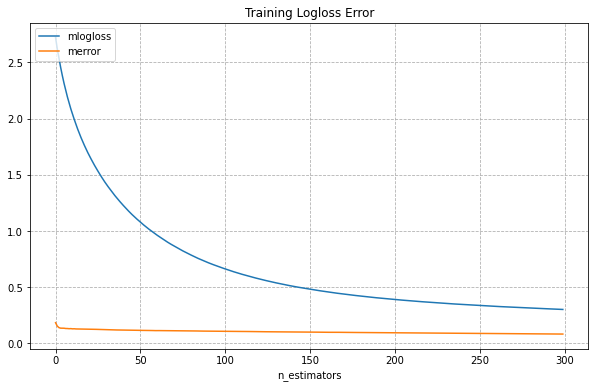

In [66]:


rcParams['figure.figsize'] = 10,6

plt.plot(evals_result.get('validation_0').get('mlogloss'))
plt.plot(evals_result.get('validation_0').get('merror'))
# plt.plot(evals_result.get('validation_1').get('mlogloss'))
plt.title('Training Logloss Error')
plt.legend(('mlogloss','merror'),loc=2)
plt.xlabel('n_estimators')
# plt.ylabel('mlogloss')
plt.grid(True, linestyle="--")
plt.savefig("mlogloss.png")
plt.show()

In [61]:
best_iteration = xgb.get_booster().best_ntree_limit
y_pred = xgb.predict(X_test, ntree_limit=best_iteration)
print(best_iteration)

190


In [67]:
print(classification_report(y_test,y_pred))

               precision    recall  f1-score   support

     Basement       0.00      0.00      0.00        10
         Bath       0.96      0.96      0.96      2190
      Bedroom       0.77      0.96      0.85      2341
       Closet       0.81      0.88      0.84       873
       Dining       0.85      0.88      0.87       294
 DraughtLobby       0.89      0.93      0.91       482
     Elevated       0.67      0.13      0.22        30
        Entry       0.91      0.93      0.92      1337
       Garage       0.81      0.59      0.69       214
         Hall       1.00      0.13      0.23        53
      Kitchen       0.97      0.95      0.96      1376
   LivingRoom       0.83      0.90      0.87      1325
      Outdoor       0.95      0.97      0.96      2376
         Room       0.55      0.07      0.13       644
      Storage       0.76      0.74      0.75       527
TechnicalRoom       0.93      0.47      0.63       151
      Utility       0.90      0.74      0.81       329

     acc